# Combining the 2022 Election Forecasts

Combining 538 [forecasts](https://projects.fivethirtyeight.com/2022-election-forecast/senate/) for US House, US Senate, and Governor seats and Louis Jacobson's state legislative [ratings](https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/) into an index to find good places to focus in 2022. 

In [1]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

# https://medium.com/@dustinmichels/three-handy-jupyter-notebook-snippets-dcb2f8ddc7db
import sys; sys.path.insert(0, '..')
from election_meta import models as m, scrape as s

In [2]:
# https://stackoverflow.com/questions/65996797
# from importlib import reload
# reload(s)
# reload(m)

# Power Sharing Model

In [3]:
state_pop = pd.read_csv('data/states/population.csv')
state_metadata = state_pop[['state', 'population']].copy()
state_converter = pd.read_csv('data/states/state_converter.csv')
state_metadata = state_metadata.merge(state_converter, on='state')
state_freq = pd.read_csv('data/states/election_frequencies.csv')

power = m.calculate_year_adjusted_seatpower(state_metadata, state_freq)
print(power.keys())
power['statehouse_power'].sort_values(
    by='potential_power', ascending=False
).head(10)

dict_keys(['statehouse_power', 'statesenate_power', 'governor_power', 'presidential_power', 'ussenate_power', 'ushouse_power'])


,state,population,state_abbr,fips,population_multiplier,election_frequency,branch,potential_power
4,California,39237836,CA,6,0.118224,2.0,statehouse,2.955602
41,Texas,29527941,TX,48,0.088968,2.0,statehouse,2.224201
8,Florida,21781128,FL,12,0.065627,2.0,statehouse,1.640670
30,New York,19835913,NY,36,0.059766,2.0,statehouse,1.494146
36,Pennsylvania,12964056,PA,42,0.039061,2.0,statehouse,0.976522
12,Illinois,12671469,IL,17,0.038179,2.0,statehouse,0.954482
19,Maryland,6165129,MD,24,0.018576,4.0,statehouse,0.928781
33,Ohio,11780017,OH,39,0.035493,2.0,statehouse,0.887333
9,Georgia,10799566,GA,13,0.032539,2.0,statehouse,0.813481
31,North Carolina,10551162,NC,37,0.031791,2.0,statehouse,0.794770


# US House

In [4]:
def process_538_legislature(dist, close_range, top, power_val):
    # Each party seatprob sums to 1, so just use one of them, assuming
    # no third parties.
    # hs_dist = hs_dist.eval('seatprob = seatprob_Dparty + seatprob_Rparty')

    # 5% margin around center
    low, high = close_range
    dist = dist.query('@low <= seatsheld <= @high')
    pr_close = dist['seatprob_Dparty'].sum()

    # Interesting, even though this isn't considered a tossup, 63.8% of probability distribution 
    # is in a close outcome. For tossup state legislatures, it's only 0.38. Hm.
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin', 'tipping'
    ]]
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()

    top['potential_power'] = power_val
    top['pr_close'] = pr_close
    top = top.eval('realized_power = potential_power*pr_close*tipping')
    # mean_netpartymargin is dem_twoparty_margin
    top = top.sort_values(by='realized_power', ascending=False)
    return top
    

In [5]:
five_data = s.get_538(
    save_loc='./data/fivethirtyeight/',
    archive_loc='./data/archive/'
)
# Only use _deluxe models:
for key, df in five_data.items(): 
    five_data[key] = df.query('expression == "_deluxe"')

Accessed: house_dist
Accessed: house_toplines
Accessed: senate_dist
Accessed: senate_toplines
Accessed: governor_toplines


In [6]:
hs_top = process_538_legislature(
    dist = five_data['house_dist'],
    close_range = [(435/2) - 0.025*435, (435/2) + 0.025*435],
    top = five_data['house_toplines'],
    power_val = power['ushouse_power']
)
hs_top['branch'] = 'ushouse'
hs_top.head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
59461,ushouse,IA-3,2022-10-22,-1.719643,6.018848,-9.513073,0.027475,IA,25.0,0.474225,0.325733
59332,ushouse,NJ-7,2022-10-22,-3.772507,5.053452,-12.628850,0.026575,NJ,25.0,0.474225,0.315063
59357,ushouse,NC-13,2022-10-22,-4.219269,3.962940,-12.390970,0.026500,NC,25.0,0.474225,0.314174
59308,ushouse,NY-22,2022-10-22,-4.022415,4.458618,-12.512080,0.026150,NY,25.0,0.474225,0.310025
59554,ushouse,CA-27,2022-10-22,-1.435974,7.073219,-9.998497,0.023963,CA,25.0,0.474225,0.284090
59272,ushouse,OR-5,2022-10-22,-1.749603,6.804623,-10.353320,0.023925,OR,25.0,0.474225,0.283646
59581,ushouse,AZ-2,2022-10-22,-2.682320,6.288738,-11.759610,0.023713,AZ,25.0,0.474225,0.281127
59396,ushouse,MI-10,2022-10-22,-5.117447,3.504339,-13.699260,0.023375,MI,25.0,0.474225,0.277125
59168,ushouse,WI-3,2022-10-22,-5.817741,2.668243,-14.252200,0.023137,WI,25.0,0.474225,0.274310
59328,ushouse,NM-2,2022-10-22,-2.430511,7.191025,-12.186190,0.022263,NM,25.0,0.474225,0.263936


In [7]:
hs_top['realized_power'].sum()

11.855624999999998

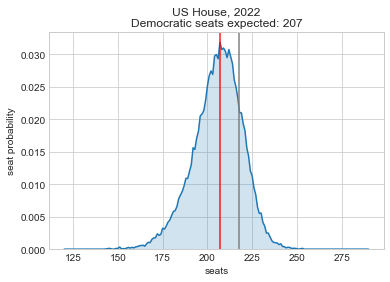

In [8]:
# hs_exp_seats = len(hs_top.query('mean_netpartymargin > 0'))
# Just find most probable seat count:
hs_exp_seats = five_data['house_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

hs_title = f'US House, 2022\nDemocratic seats expected: {hs_exp_seats}'
m.plot_seatprob(
    x = five_data['house_dist']['seatsheld'],
    y = five_data['house_dist']['seatprob_Dparty'],
    mean_outcome = hs_exp_seats,
    midpoint=217.5,
    title=hs_title,
    x_label='seats',
    y_label='seat probability',
    out='data/output/househist.png'
)

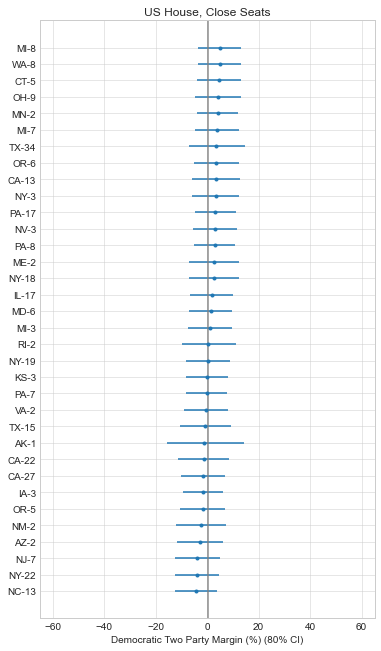

In [9]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
hsplot = hs_top.copy()
hsplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
hsplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
hsplot = hsplot.sort_values(by='mean_netpartymargin', ascending=True)
hsplot.reset_index(drop=True, inplace=True)
#hsplot = hsplot.loc[192:243]
hsplot = hsplot.query('-5 <= mean_netpartymargin <= 5')
m.seatplot(
    hsplot,
    x='mean_netpartymargin',
    y='district',
    title='US House, Close Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/houseseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# US Senate

In [10]:
sen_top = process_538_legislature(
    dist = five_data['senate_dist'],
    close_range = [50 - 2.5, 50 + 2.5],
    top = five_data['senate_toplines'],
    power_val = power['ussenate_power']
)
sen_top['branch'] = 'ussenate'
sen_top.head()

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,tipping,state_abbr,potential_power,pr_close,realized_power
4786,ussenate,GA-S3,2022-10-22,1.092869,8.573341,-6.408848,0.146037,GA,25.0,0.6798,2.481907
4766,ussenate,PA-S3,2022-10-22,1.254288,9.011929,-6.534367,0.139637,PA,25.0,0.6798,2.373139
4772,ussenate,NV-S3,2022-10-22,-0.707256,7.614769,-9.022049,0.134850,NV,25.0,0.6798,2.291776
4791,ussenate,AZ-S3,2022-10-22,3.871872,11.657250,-3.947275,0.093525,AZ,25.0,0.6798,1.589457
4760,ussenate,WI-S3,2022-10-22,-4.216843,3.473469,-12.147270,0.092613,WI,25.0,0.6798,1.573949


In [11]:
sen_top['realized_power'].sum()

16.994999999999997

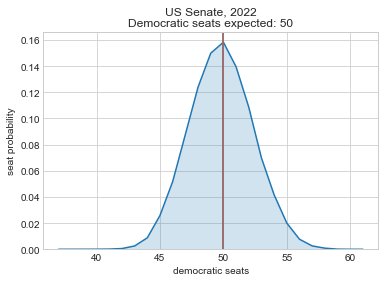

In [12]:
#sen_exp_seats = 36 + len(sen_top.query('mean_netpartymargin > 0')) # 36 seats not up
# Just find most probable seat count:
sen_exp_seats = five_data['senate_dist'].sort_values(
    by='seatprob_Dparty', ascending=False
)['seatsheld'].iloc[0]

sen_title = f'US Senate, 2022\nDemocratic seats expected: {sen_exp_seats}'
m.plot_seatprob(
    x = five_data['senate_dist']['seatsheld'],
    y = five_data['senate_dist']['seatprob_Dparty'],
    mean_outcome = sen_exp_seats,
    midpoint=50,
    title=sen_title,
    x_label='democratic seats',
    y_label='seat probability',
    out='data/output/senatehist.png'
)

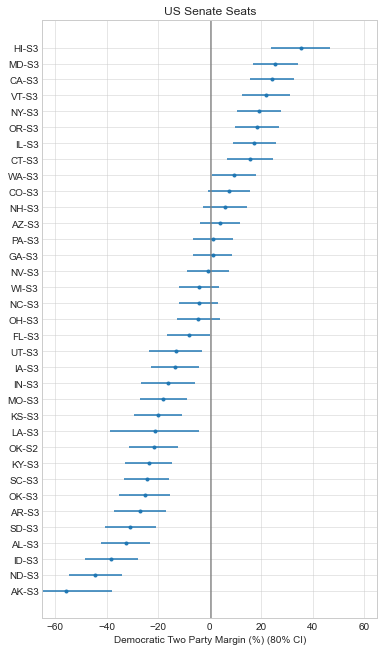

In [13]:
#def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], outcome=None, out=None):
senplot = sen_top.copy()
senplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
senplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
senplot = senplot.sort_values(by='mean_netpartymargin', ascending=True)
senplot.reset_index(drop=True, inplace=True)
m.seatplot(
    senplot,
    x='mean_netpartymargin',
    y='district',
    title='US Senate Seats',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/senateseats.png'
)
# Two party voteshare should be 0 to 100. This is party margin, which is fine too
# just be aware of that for other calculations, probably not relevant because 
# tips and pr_close are already calculated using hists or included. This is just
# cosmetic for plotting.

# Governors

In [14]:
# https://www.sciencedirect.com/topics/engineering/confidence-interval
# https://mathworld.wolfram.com/StandardDeviation.html
# Assuming normal, 80% CI = mean +- 1.282*SD
# So for WY governor:
# se = (53-38)/1.282
# se

In [15]:
# Instead of simulating, just integrate estimated normal distributions
def estimate_prclose(row):
    dist = stats.norm(
        loc=row['mean_netpartymargin'],
        scale=row['stdev']
    )
    # Integrate around central outcome, in this case 0 is tie
    pr_close = dist.cdf(2.5) - dist.cdf(-2.5)
    return pr_close

def process_538_governors(top, power):
    top = top.copy()
    top = top[[
        'branch', 'district', 'forecastdate', 'mean_netpartymargin',
        'p90_netpartymargin', 'p10_netpartymargin'
    ]]
    # 'tipping', what is tipping in the context of Governors? Tip what?
    top['forecastdate'] = pd.to_datetime(top['forecastdate'])
    top = top.sort_values(by='forecastdate', ascending=False)
    top = top.groupby(by='district').head(1)
    
    top['state_abbr'] = top['district'].str[0:2]
    top['branch'] = top['branch'].str.lower()
    
    # https://mathworld.wolfram.com/StandardDeviation.html
    # 80% CI is roughly 1.28 sigma
    top.eval('stdev = (p90_netpartymargin - mean_netpartymargin)/1.28155', inplace=True)
    top['pr_close'] = top.apply(estimate_prclose, axis=1)
    
    gov_pow = power[['state_abbr', 'potential_power']].copy()
    top = top.merge(gov_pow, on='state_abbr')
    top['pr_tip'] = 1
    top.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
    
    return top

In [16]:
gov_top = process_538_governors(five_data['governor_toplines'], power['governor_power'])
gov_top.sort_values(by='realized_power', ascending=False).head(10)

,branch,district,forecastdate,mean_netpartymargin,p90_netpartymargin,p10_netpartymargin,state_abbr,stdev,pr_close,potential_power,pr_tip,realized_power
12,governor,AZ-G1,2022-10-22,-1.158607,5.902374,-8.344528,AZ,5.509719,0.342839,2.192363,1,0.751628
18,governor,GA-G1,2022-10-22,-7.016853,0.146946,-14.206350,GA,5.589949,0.165205,3.253923,1,0.537564
16,governor,WI-G1,2022-10-22,0.580662,8.792606,-7.822960,WI,6.407822,0.302391,1.776444,1,0.537181
19,governor,MI-G1,2022-10-22,7.275047,15.205280,-0.587612,MI,6.188001,0.163067,3.028322,1,0.493819
22,governor,TX-G1,2022-10-22,-11.895350,-4.002888,-19.739990,TX,6.158528,0.053849,8.896806,1,0.479087
8,governor,FL-G1,2022-10-22,-10.773910,-3.044146,-18.535840,FL,6.031574,0.071191,6.562681,1,0.467202
27,governor,PA-G1,2022-10-22,8.547207,15.575130,1.475372,PA,5.483924,0.113095,3.906086,1,0.441760
20,governor,OR-G1,2022-10-22,-0.078892,8.454529,-8.673935,OR,6.658672,0.292655,1.279372,1,0.374414
31,governor,NY-G1,2022-10-22,11.855460,20.261360,3.334534,NY,6.559167,0.062576,5.976585,1,0.373989
32,governor,NV-G1,2022-10-22,0.394150,9.164816,-8.264740,NV,6.843796,0.284657,0.947288,1,0.269652


In [17]:
gov_top['realized_power'].sum()

5.714873128743923

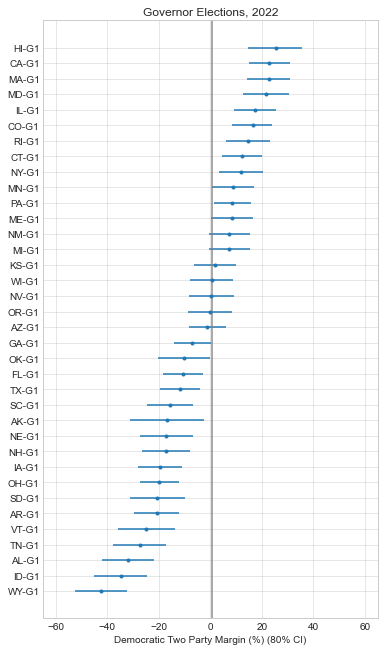

In [18]:
govplot = gov_top.copy()
govplot.eval('lower = mean_netpartymargin - p10_netpartymargin', inplace=True)
govplot.eval('upper = p90_netpartymargin - mean_netpartymargin', inplace=True)
govplot = govplot.sort_values(by='mean_netpartymargin', ascending=True)
govplot.reset_index(drop=True, inplace=True)
m.seatplot(
    govplot,
    x='mean_netpartymargin',
    y='district',
    title='Governor Elections, 2022',
    x_label='Democratic Two Party Margin (%) (80% CI)',
    xlim=(-65, 65),
    out='data/output/govseats.png'
)

# State Legislatures

In [19]:
j_categories = pd.read_csv('./data/output/jacobson_category_summary.csv')
j_categories.rename(
    columns={'jacobsonforecast': 'forecast', 'mean': 'dem_seatshare'},
    inplace=True
)
j_categories

,jacobsonforecastnumeric,forecast,dem_seatshare,std,pr_close,CI80_lower,CI80_upper
0,1.0,Safe R,28.697171,9.083162,0.003717,15.991489,40.322580
1,2.0,Likely R,38.826987,6.436138,0.018692,30.000000,45.900000
2,3.0,Lean R,42.848929,6.444749,0.139535,35.676768,50.633354
3,4.0,Toss-up,50.385232,6.223403,0.378049,41.666667,58.192256
4,5.0,Lean D,55.589494,5.377861,0.213115,49.253731,63.265300
5,6.0,Likely D,58.606672,5.866417,0.053571,51.931926,64.857145
6,7.0,Safe D,72.247156,10.883517,0.004854,60.000000,87.500000


In [20]:
state_forecasts = s.get_jacobson(
    save_loc='./data/jacobson/',
    archive_loc='./data/archive/'
)
# Inner join removes states without elections
state_forecasts = state_forecasts.merge(j_categories, on='forecast')
state_forecasts = state_forecasts.merge(state_converter[['state','state_abbr']], on='state')
state_forecasts

Accessed:  https://centerforpolitics.org/crystalball/articles/the-battle-for-the-state-legislatures/


,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr
0,Alabama,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
1,Alabama,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AL
2,Arkansas,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
3,Arkansas,senate,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,AR
4,Florida,house,Safe R,1.0,28.697171,9.083162,0.003717,15.991489,40.322580,FL
...,...,...,...,...,...,...,...,...,...,...
81,New Mexico,house,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,NM
82,Oregon,house,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,OR
83,Oregon,senate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,OR
84,Maine,house,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME


In [21]:
st_sen = state_forecasts.query('office == "senate"')
st_sen = st_sen.merge(
    power['statesenate_power'][['state', 'potential_power']],
    on='state'
)
st_sen['pr_tip'] = 1
st_sen.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_sen['office'] = 'statesenate'
st_sen.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
19,Michigan,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MI,0.757080,1,0.286213
32,New York,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,NY,1.494146,1,0.080044
39,Oregon,statesenate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,OR,0.319843,1,0.068163
20,Minnesota,statesenate,Lean R,3.0,42.848929,6.444749,0.139535,35.676768,50.633354,MN,0.429911,1,0.059988
37,Illinois,statesenate,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
38,Nevada,statesenate,Lean D,5.0,55.589494,5.377861,0.213115,49.253731,63.265300,NV,0.236822,1,0.050470
40,Maine,statesenate,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
2,Florida,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,FL,1.640670,1,0.030667
26,Pennsylvania,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,PA,0.976522,1,0.018253
22,Georgia,statesenate,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,GA,0.813481,1,0.015205


In [22]:
st_sen['realized_power'].sum()

0.7998744384448527

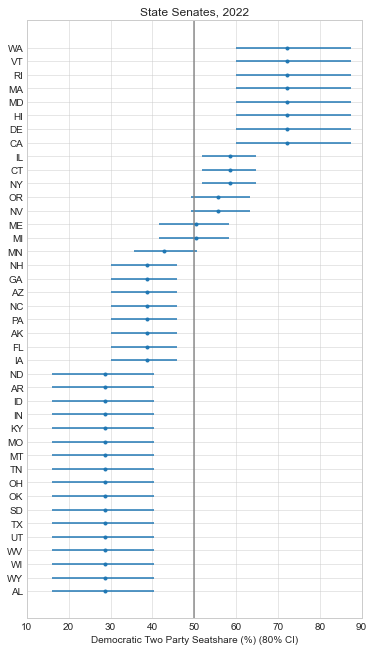

In [23]:
stsen_plot = st_sen.copy()
stsen_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
stsen_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
stsen_plot = stsen_plot.sort_values(by='dem_seatshare', ascending=True)
stsen_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    stsen_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Senates, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90), 
    midpoint=50,
    out='data/output/statesenateseats.png'
)

In [24]:
st_hs = state_forecasts.query('office == "house"')
st_hs = st_hs.merge(
    power['statehouse_power'][['state', 'potential_power']],
    on='state'
)
st_hs['pr_tip'] = 1
st_hs.eval('realized_power = potential_power*pr_close*pr_tip', inplace=True)
st_hs['office'] = 'statehouse'
st_hs.sort_values(by='realized_power', ascending=False).head(10)

,state,office,forecast,jacobsonforecastnumeric,dem_seatshare,std,pr_close,CI80_lower,CI80_upper,state_abbr,potential_power,pr_tip,realized_power
22,Minnesota,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,MN,0.429911,1,0.162527
21,Michigan,statehouse,Lean R,3.0,42.848929,6.444749,0.139535,35.676768,50.633354,MI,0.757080,1,0.105639
40,Illinois,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,IL,0.954482,1,0.051133
44,Maine,statehouse,Toss-up,4.0,50.385232,6.223403,0.378049,41.666667,58.192256,ME,0.103365,1,0.039077
38,Colorado,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CO,0.437796,1,0.023453
28,Pennsylvania,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,PA,0.976522,1,0.018253
43,Oregon,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,OR,0.319843,1,0.017134
24,Georgia,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,GA,0.813481,1,0.015205
27,North Carolina,statehouse,Likely R,2.0,38.826987,6.436138,0.018692,30.000000,45.900000,NC,0.794770,1,0.014856
39,Connecticut,statehouse,Likely D,6.0,58.606672,5.866417,0.053571,51.931926,64.857145,CT,0.271593,1,0.014550


In [25]:
st_hs['realized_power'].sum()

0.5766057154064279

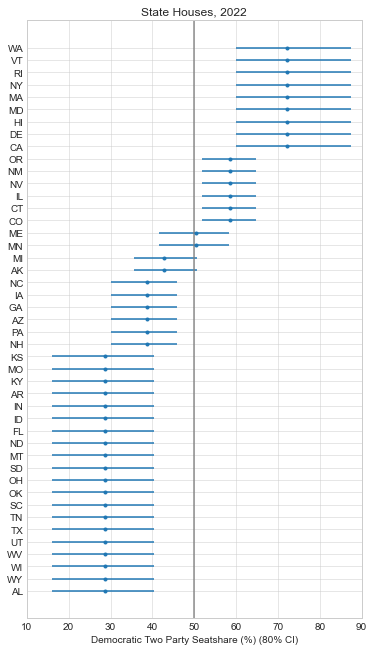

In [26]:
sths_plot = st_hs.copy()
sths_plot.eval('lower = dem_seatshare - CI80_lower', inplace=True)
sths_plot.eval('upper = CI80_upper - dem_seatshare', inplace=True)
sths_plot = sths_plot.sort_values(by='dem_seatshare', ascending=True)
sths_plot.reset_index(drop=True, inplace=True)
m.seatplot(
    sths_plot,
    x='dem_seatshare',
    y='state_abbr',
    title='State Houses, 2022',
    x_label='Democratic Two Party Seatshare (%) (80% CI)',
    xlim=(10, 90),
    midpoint=50,
    out='data/output/statehouseseats.png'
)

# Funding Analysis

In [27]:
state_funding = s.get_followthemoney(
    save_loc='./data/funding/',
    archive_loc='./data/archive/'
)
#state_funding = pd.read_csv('./data/funding/state_funds.csv')
def match_branch(el):
    matches = {
        'Gubernatorial': 'governor',
        'State House/Assembly': 'statehouse',
        'State Senate': 'statesenate'
    }
    return matches[el]

def label_district(row):
    if row['branch'] == 'governor':
        row['district'] = row['district'] + '-G1'
    return row

office_list = ['Gubernatorial', 'State House/Assembly', 'State Senate']
state_funding = state_funding.query('General_Office.isin(@office_list)')
state_funding['branch'] = state_funding['General_Office'].apply(match_branch)
state_funding.rename(
    columns={'Election_Jurisdiction':'district', 'Total_$':'funding'},
    inplace=True
)
state_funding = state_funding[['branch', 'district', 'funding']]
state_funding = state_funding.apply(label_district, axis=1)
state_funding = state_funding.sort_values(by='branch')
state_funding.head(5)

,branch,district,funding
0,governor,IL-G1,2.398908e+08
32,governor,CT-G1,1.817670e+07
35,governor,CO-G1,1.547576e+07
37,governor,RI-G1,1.488745e+07
40,governor,MA-G1,1.469288e+07


In [28]:
fed_funding = s.get_fec(
    save_loc='./data/funding/',
    archive_loc='./data/archive/'
)
fed_candidates = pd.read_csv(
    './data/funding/federal_candidates.csv',
    sep='|',
    dtype='object'
)
sel_cols = ['CAND_ID', 'CAND_ELECTION_YR', 'CAND_OFFICE']
fed_candidates = fed_candidates[sel_cols]
fed_2022 = fed_funding.merge(fed_candidates, on='CAND_ID')
fed_2022 = fed_2022.query('CAND_ELECTION_YR == "2022"')
data_cols = ['TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TRANS_TO_AUTH']
fed_2022[data_cols] = fed_2022[data_cols].apply(pd.to_numeric, axis=1)
# Subtract off double counted activity
# https://www.fec.gov/campaign-finance-data/all-candidates-file-description/
fed_2022.eval(
    'NET_RECEIPTS = TTL_RECEIPTS - TRANS_FROM_AUTH - TRANS_TO_AUTH',
    inplace=True
)
fed_2022.head(5)

,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,CAND_ELECTION_YR,CAND_OFFICE,NET_RECEIPTS
0,H2AK00200,"CONSTANT, CHRISTOPHER",C,1,DEM,164637.90,0.00,164037.51,0.0,0,...,NaN,NaN,1000,5000,09/30/2022,8300,0,2022,H,164637.90
1,H2AK01158,"PELTOLA, MARY",I,1,DEM,4222293.36,0.00,1956492.82,0.0,0,...,NaN,NaN,199663.36,5000,09/30/2022,47782.5,500,2022,H,4222293.36
2,H2AK01240,"WOOL, ADAM L",O,1,DEM,16217.07,0.00,16217.07,0.0,0,...,NaN,NaN,0,0,07/15/2022,0,0,2022,H,16217.07
3,H2AK00218,"REVAK, JOSHUA CARL",O,2,REP,121841.00,0.00,121841,0.0,0,...,NaN,NaN,5000,0,09/16/2022,14600,0,2022,H,121841.00
4,H2AK00226,"PALIN, SARAH",O,2,REP,1556120.28,112737.77,1361350.32,0.0,0,...,NaN,NaN,69905,0,09/30/2022,500,0,2022,H,1443382.51


In [29]:
senate_funding = fed_2022.query('CAND_OFFICE == "S"')
# For now, just calculate total funding. Maybe a better measure of effort.
# Includes primary challengers.
# # Take top fund getter by party and state
# senate_funding = senate_funding.sort_values(by='NET_RECEIPTS', ascending=False)
# senate_funding = senate_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_PTY_AFFILIATION']
# ).head(1)
# # Then take the top two fund getters by election.
# # Results in 68 records, 2 for every race.
# senate_funding = senate_funding.groupby(
#     by=['CAND_OFFICE_ST']
# ).head(2)
senate_funding = senate_funding.groupby(
    by=['CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']
).agg({'NET_RECEIPTS': 'sum'})
senate_funding.reset_index(drop=False, inplace=True)
senate_funding['branch'] = 'ussenate'
senate_funding['district'] = senate_funding['CAND_OFFICE_ST'] + '-S3'
senate_funding.rename(columns={'NET_RECEIPTS': 'funding'}, inplace=True)
senate_funding = senate_funding[['branch', 'district', 'funding']]
senate_funding.head(5)

,branch,district,funding
0,ussenate,AK-S3,1.244265e+07
1,ussenate,AL-S3,3.049097e+07
2,ussenate,AR-S3,7.781922e+06
3,ussenate,AZ-S3,1.078949e+08
4,ussenate,CA-S3,2.171397e+07


In [30]:
house_funding = fed_2022.query('CAND_OFFICE == "H"')
# For now, include all funding, including primary challengers. This matches
# the state level data, maybe is a better measure of "total effort" put into races.
# # Take top fund getter by party, state, district
# house_funding = house_funding.sort_values(by='NET_RECEIPTS', ascending=False)
# house_funding = house_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'CAND_PTY_AFFILIATION']
# ).head(1)
# # Then take the top two fund getters by election.
# # Results in 846 records, some races aren't contested?
# house_funding = house_funding.groupby(
#     by=['CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT']
# ).head(2)
house_funding = house_funding.groupby(
    by=['CAND_OFFICE_ST','CAND_OFFICE_DISTRICT']
).agg({'NET_RECEIPTS': 'sum'})
house_funding.reset_index(drop=False, inplace=True)
house_funding['branch'] = 'ushouse'
# Needs to be int to match 538
house_funding['CAND_OFFICE_DISTRICT'] = house_funding['CAND_OFFICE_DISTRICT'].astype('int')
house_funding['CAND_OFFICE_DISTRICT'] = house_funding['CAND_OFFICE_DISTRICT'].astype('string')
house_funding['district'] = house_funding['CAND_OFFICE_ST'] + '-' + house_funding['CAND_OFFICE_DISTRICT']
house_funding.rename(columns={'NET_RECEIPTS': 'funding'}, inplace=True)
house_funding = house_funding[['branch', 'district', 'funding']]
house_funding.head(5)
# There are a few territories included, so not exactly 435
# Just left join the power values onto it. 

,branch,district,funding
0,ushouse,AK-0,9245905.68
1,ushouse,AL-1,738284.91
2,ushouse,AL-2,1281364.42
3,ushouse,AL-3,1700554.77
4,ushouse,AL-4,1408566.52


In [31]:
all_funding = pd.concat([state_funding, house_funding, senate_funding])
all_funding #.head(5)

,branch,district,funding
0,governor,IL-G1,2.398908e+08
32,governor,CT-G1,1.817670e+07
35,governor,CO-G1,1.547576e+07
37,governor,RI-G1,1.488745e+07
40,governor,MA-G1,1.469288e+07
...,...,...,...
29,ussenate,SD-S3,6.504817e+06
30,ussenate,UT-S3,1.488366e+07
31,ussenate,VT-S3,6.359043e+06
32,ussenate,WA-S3,2.504857e+07


# Cumulative Results

In [32]:
# Relabel and standardise data for combination, output
out_cols = [
    'branch', 'district', 'state_abbr', 'forecast_measure',
    'forecast', 'ci_low', 'ci_high', 'ci_measure', 'potential_power',
    'pr_close', 'pr_tip', 'realized_power'
]

final_dfs = []

for df in [sen_top, hs_top, gov_top]:
    df = df.copy()
    df['forecast_measure'] = 'net_dem_twoparty_margin'
    df['ci_measure'] = '80pct'
    df.rename(
        columns={
            'tipping':'pr_tip',
            'mean_netpartymargin': 'forecast',
            'p10_netpartymargin': 'ci_low',
            'p90_netpartymargin': 'ci_high',
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
for df in [st_sen, st_hs]:
    df = df.copy()
    df['forecast_measure'] = 'dem_twoparty_seatshare'
    df['ci_measure'] = '80pct'
    df['district'] = df['state_abbr']
    del df['forecast']
    df.rename(
        columns={
            'dem_seatshare': 'forecast',
            'CI80_lower': 'ci_low',
            'CI80_upper': 'ci_high',
            'office':'branch'
        },
        inplace=True
    )
    df = df[out_cols]
    final_dfs.append(df)
    
cumulative_df = pd.concat(final_dfs)
cumulative_df = cumulative_df.sort_values(
    by='realized_power',
    ascending=False
).reset_index(drop=True)
cumulative_df = cumulative_df.merge(
    all_funding,
    on=['branch', 'district'],
    how='left'
)
cumulative_df['power_pct'] = cumulative_df['realized_power']*100/cumulative_df['realized_power'].sum()
cumulative_df['funding_pct'] = cumulative_df['funding']*100/cumulative_df['funding'].sum()
cumulative_df.eval('funding_gap = power_pct - funding_pct', inplace=True)
cumulative_df.sort_values(by='funding_gap', ascending=False, inplace=True)
cumulative_df.to_csv('data/output/all_elections.csv', index=False)
cumulative_df.head(50)

,branch,district,state_abbr,forecast_measure,forecast,ci_low,ci_high,ci_measure,potential_power,pr_close,pr_tip,realized_power,funding,power_pct,funding_pct,funding_gap
2,ussenate,NV-S3,NV,net_dem_twoparty_margin,-0.707256,-9.022049,7.614769,80pct,25.000000,0.679800,0.134850,2.291776,5.001474e+07,6.376321,0.936663,5.439657
0,ussenate,GA-S3,GA,net_dem_twoparty_margin,1.092869,-6.408848,8.573341,80pct,25.000000,0.679800,0.146037,2.481907,1.457496e+08,6.905316,2.729561,4.175755
1,ussenate,PA-S3,PA,net_dem_twoparty_margin,1.254288,-6.534367,9.011929,80pct,25.000000,0.679800,0.139637,2.373139,1.322131e+08,6.602695,2.476053,4.126642
5,ussenate,NC-S3,NC,net_dem_twoparty_margin,-4.375084,-12.004270,3.245075,80pct,25.000000,0.679800,0.090163,1.532312,5.011626e+07,4.263293,0.938565,3.324728
4,ussenate,WI-S3,WI,net_dem_twoparty_margin,-4.216843,-12.147270,3.473469,80pct,25.000000,0.679800,0.092613,1.573949,6.963352e+07,4.379140,1.304079,3.075061
3,ussenate,AZ-S3,AZ,net_dem_twoparty_margin,3.871872,-3.947275,11.657250,80pct,25.000000,0.679800,0.093525,1.589457,1.078949e+08,4.422287,2.020628,2.401659
6,ussenate,OH-S3,OH,net_dem_twoparty_margin,-4.451309,-12.884120,3.949787,80pct,25.000000,0.679800,0.086337,1.467306,9.053565e+07,4.082429,1.695529,2.386900
7,ussenate,NH-S3,NH,net_dem_twoparty_margin,5.790474,-2.796957,14.262540,80pct,25.000000,0.679800,0.062337,1.059426,3.441754e+07,2.947600,0.644563,2.303037
8,governor,AZ-G1,AZ,net_dem_twoparty_margin,-1.158607,-8.344528,5.902374,80pct,2.192363,0.342839,1.000000,0.751628,3.551802e+07,2.091225,0.665172,1.426052
9,ussenate,CO-S3,CO,net_dem_twoparty_margin,7.579399,-0.634359,15.769540,80pct,25.000000,0.679800,0.036862,0.626478,2.567293e+07,1.743026,0.480796,1.262230


In [33]:
# A few missing records
cumulative_df[cumulative_df['funding'].isnull()]

,branch,district,state_abbr,forecast_measure,forecast,ci_low,ci_high,ci_measure,potential_power,pr_close,pr_tip,realized_power,funding,power_pct,funding_pct,funding_gap
59,ushouse,AK-1,AK,net_dem_twoparty_margin,-1.070866,-15.469050,14.35927,80pct,25.0,0.474225,0.012500,0.148195,NaN,0.412318,NaN,NaN
137,ussenate,OK-S2,OK,net_dem_twoparty_margin,-21.815570,-31.478300,-12.28221,80pct,25.0,0.679800,0.001150,0.019544,NaN,0.054377,NaN,NaN
233,ushouse,DE-1,DE,net_dem_twoparty_margin,14.823400,6.508623,23.09829,80pct,25.0,0.474225,0.000287,0.003408,NaN,0.009483,NaN,NaN
244,ushouse,ND-1,ND,net_dem_twoparty_margin,-62.944390,-36.355850,-15.54000,80pct,25.0,0.474225,0.000225,0.002668,NaN,0.007422,NaN,NaN
452,ushouse,WY-1,WY,net_dem_twoparty_margin,-49.414030,-59.004490,-39.81219,80pct,25.0,0.474225,0.000000,0.000000,NaN,0.000000,NaN,NaN
524,ushouse,SD-1,SD,net_dem_twoparty_margin,-84.457580,-90.713900,-77.66174,80pct,25.0,0.474225,0.000000,0.000000,NaN,0.000000,NaN,NaN
548,ushouse,VT-1,VT,net_dem_twoparty_margin,29.060200,18.827560,39.09565,80pct,25.0,0.474225,0.000000,0.000000,NaN,0.000000,NaN,NaN


In [34]:
#sns.lmplot(data=cumulative_df, x="power_pct", y="funding_pct", hue='branch')
#sns.scatterplot(data=cumulative_df, x="power_pct", y="funding_pct", hue='branch')

In [35]:
matrix = cumulative_df.groupby(by=['state_abbr', 'branch']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state_abbr', columns='branch', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
matrix.to_csv('data/output/statescore-matrix.csv', index=True)

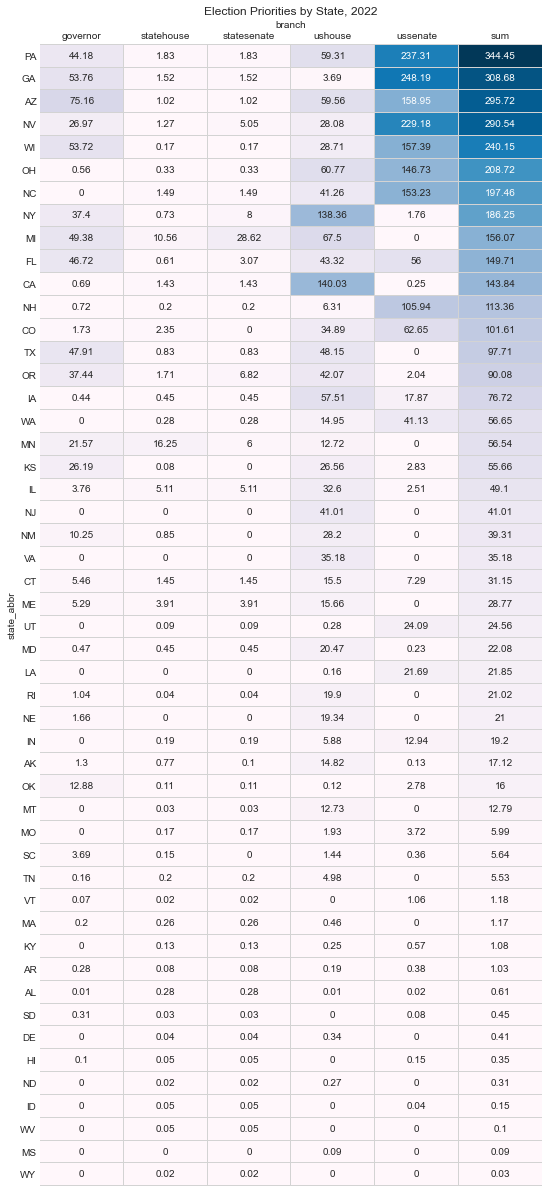

In [36]:
#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[9,21]) #[9, 20] [7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(matrix, decimals=2),
    ax=ax, annot=True, fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=False, cmap='PuBu') 
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
plt.title('Election Priorities by State, 2022')
plt.savefig('../heatmap.png', bbox_inches='tight')
heatmap

In [37]:
summary_df = cumulative_df.groupby(
    by='branch'
).agg(
    {'realized_power':'sum', 'funding': 'sum'}
).sort_values(
    by='realized_power',
    ascending=False
)
summary_df.reset_index(drop=False, inplace=True)

# Funding now from aggregation above, from race level data
# State Legislative funding:
# https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
# https://www.opensecrets.org/news/2022/03/a-behind-the-scenes-look-at-collecting-state-campaign-finance-data-in-2022/
# By state and office: https://www.followthemoney.org/show-me#[{1|gro=y,c-r-ot,s
# https://www.followthemoney.org/show-me#[{1|gro=y,c-r-ot,d-ad-st
# Federal data:
# https://www.fec.gov/data/raising-bythenumbers/
# https://www.opensecrets.org/elections-overview
# funding = pd.DataFrame({
#     'branch': ['ussenate', 'ushouse', 'governor', 'statesenate', 'statehouse'],
#     'funding': [1057769329, 1527419371, 1427297635, 343214789, 536928934]
# })
# summary_df = summary_df.merge(funding, on='branch')

summary_df.eval('power_pct = 100*realized_power/realized_power.sum()', inplace=True)
summary_df.eval('funding_pct = 100*funding/funding.sum()', inplace=True)
#del summary_df['funding']
summary_df.eval('funding_gap = power_pct - funding_pct', inplace=True)
print('https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y')
print('https://www.fec.gov/data/raising-bythenumbers/')

summary_df.set_index('branch', inplace=True)

summary_df = summary_df.style.format({
    "realized_power": "{:.1f}",
    "power_pct": "{:.1f}",
    "funding_pct": "{:.1f}",
    "funding_gap": "{:.1f}",
    "funding": "{:20,.2f}"
}).background_gradient(
    #subset=['power_pct', 'funding_pct', 'funding_gap']
)
m.output_table(summary_df, './data/output/power_frac.html')
summary_df

https://www.followthemoney.org/show-me#[{1|gro=c-r-ot,y
https://www.fec.gov/data/raising-bythenumbers/


,realized_power,funding,power_pct,funding_pct,funding_gap
branch,,,,,
ussenate,17.0,"1,194,452,911.48",47.3,22.4,24.9
ushouse,11.9,"1,741,372,004.06",33.0,32.6,0.4
governor,5.7,"1,469,508,488.42",15.9,27.5,-11.6
statesenate,0.8,"362,349,984.04",2.2,6.8,-4.6
statehouse,0.6,"571,987,270.72",1.6,10.7,-9.1


In [46]:
datatable_def = '''{
    columnDefs: [
        { 'targets': [5,6,7,8], type:'num'}
    ],
    autoWidth: true,
    paging: false,
    scrollY: 600,
    scrollX: 900,
    order: [[8, 'desc']],
}'''

out_table = cumulative_df.copy()
out_table = out_table[[
    'branch', 'district', 'state_abbr',
    'forecast', 'realized_power', 'power_pct', 'funding_pct',
    'funding_gap'
]]
# Remove missing funding, about 5 districts
out_table = out_table[~out_table['funding_pct'].isnull()]
out_table.reset_index(drop=True, inplace=True)
out_table = out_table.style.background_gradient(
        subset=[
            'realized_power', 'power_pct',
            'funding_pct', 'funding_gap'
        ]
    ).set_precision(2) \
    .set_table_attributes('class="row-border responsive compact stripe hover" style="width:100%"') \
    .render()
m.output_interactive_table(
    table=out_table,
    datatable_def=datatable_def,
    outpath='./data/output/office_table.html'
)

In [48]:
# Output
# !cp -vr data/output/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta-2022